In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import oracledb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

sns.set(rc={'figure.figsize':(10,5)}, font_scale = 1.25)

load_dotenv()

True

## Connect to Oracle Cloud Autonomous Database containing Baseball Statistics

In [150]:
oracledb.init_oracle_client()
try:
    connection = oracledb.connect(user = 'ADMIN', password = os.environ.get('ORACLE_DB_PASS'),
                       dsn = os.environ.get("DSN"))
    c = connection.cursor()
except oracledb.Error as error:
    print(error)


In [151]:
def execute(query):
    """
    Function to execute SQL queries, minimize redundant code downstream
    
    """
    res = c.execute(query)

    return res.fetchall()

def read_table(table_name):
    
    """
    Function to query all objects in SQLite table, return a pandas DataFrame object
    
    """
    
    table = execute(f"SELECT * FROM {table_name} WHERE YEARID > 2000")
    
    columns = execute(f"SELECT column_name FROM all_tab_columns WHERE TABLE_NAME = '{table_name}'")
    
    columns = pd.DataFrame(columns)[0].to_list()
    
    table_df = pd.DataFrame(table, columns = np.array(columns)).convert_dtypes(infer_objects=True)
    
    return table_df

In [152]:
tables = execute("SELECT table_name FROM user_tables")
tables = pd.DataFrame(tables, columns = ["TableID"])
tables

,TableID
0,FIELDING
1,ALLSTARFULL
2,APPEARANCES
3,BATTINGPOST
4,FIELDINGOFSPLIT
5,FIELDINGOF
6,FIELDINGPOST
7,HOMEGAMES
8,MANAGERS
9,MANAGERSHALF


In [153]:
all_teams = read_table('TEAMS').sort_values(by = "YEARID")
cols = ['SB', 'HBP', 'SF']
all_teams[cols] = all_teams[cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)
all_teams['YEARID'] = all_teams['YEARID'].astype('string')
# all_teams = all_teams.loc[all_teams['YEARID'] != '2020']
all_teams['TEAMID'] = all_teams['TEAMID'].replace({'FLO':'MIA'})

In [154]:
all_teams.columns

Index(['YEARID', 'LGID', 'TEAMID', 'FRANCHID', 'DIVID', 'RANK', 'G', 'GHOME',
       'W', 'L', 'DIVWIN', 'WCWIN', 'LGWIN', 'WSWIN', 'R', 'AB', 'H',
       'DOUBLES', 'TRIPLES', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA',
       'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPOUTS', 'HA', 'HRA', 'BBA', 'SOA',
       'E', 'DP', 'FP', 'NAME', 'PARK', 'ATTENDANCE', 'BPF', 'PPF', 'TEAMIDBR',
       'TEAMIDLAHMAN45', 'TEAMIDRETRO'],
      dtype='object')

<html>
<style>
table, th, td {
  border:1px solid black;
}
</style>
<body>
<h2>Incorporated Formulas--Feature Engineering</h2>
<table>
  <tr>
  <td>Plate Appearances (PA)<td>
  <td>AB + BB + HBP + SF + SH + defensive interference<td>    
  </tr>
  <tr>
  <td>On Base Percentage Divisor (PA*)<td>
  <td>AB + BB + HBP + SF<td>    
  </tr>
  <tr>
  <td>Total Bases<td>
  <td>[H + 2B + (2 X 3B) + (3 X HR)]<td>    
  </tr>
  <tr>
  <td>Batting Average (AVG)<td>
  <td>H/AB<td>    
  </tr>
  <tr>
  <td>On Base Percentage (OBP)<td>
  <td>(H + BB + HBP)/(AB + BB + HBP + SF)<td>    
  </tr>
  <tr>
  <td>Slugging Percentage (SLG)<td>
  <td>TB/AB<td>    
  </tr>
  <tr>
  <td>On Base + Slugging Percentage (OPS)<td>
  <td>OBP + SLG<td>    
  </tr>
  <tr>
  <td>K/BB Ratio<td>
  <td>K/BB<td>    
  </tr>
  <tr>
  <td>W Percentage<td>
  <td>W/(W+L)<td>    
  </tr>
</table>

</body>
</html>

In [155]:
# Total Bases
all_teams['TB'] = all_teams['H'] + all_teams['DOUBLES'] + (2 * all_teams['TRIPLES']) + (3 * all_teams['HR'])
# Batting Average
all_teams['AVG'] = all_teams['H']/all_teams['AB']
# Plate Appearances *, OBP divisor
all_teams['PA*'] = all_teams['AB'] + all_teams['BB'] + all_teams['HBP'] + all_teams['SF']
# On-Base Percentage
all_teams['OBP'] = (all_teams['H'] + all_teams['BB'] + all_teams['HBP'])/all_teams['PA*']
# Slugging Percentage
all_teams['SLG'] = all_teams['TB']/all_teams['AB']
# OBP + SLG
all_teams['OPS'] = all_teams['OBP'] + all_teams['SLG']
# Strikeout/Base-on-Balls
all_teams['K/BB'] = all_teams['SOA']/all_teams['BBA']

all_teams['Playoff_Appearance'] = np.where(all_teams["WCWIN"]=='Y', 'Y', np.where(all_teams['DIVWIN']=='Y', 'Y', 'N'))
all_teams.drop(columns=['W', 'L', 'G', 'RANK', 'BPF', 'PPF', 'FP', 'TRIPLES', 'H', 'AB'], inplace = True)
num_cols = all_teams.select_dtypes(['integer', 'float']).columns.to_list()
cat_cols = all_teams.select_dtypes(['string']).columns.to_list()
all_teams.sort_values(by = 'YEARID')
all_teams.head()

,YEARID,LGID,TEAMID,FRANCHID,DIVID,GHOME,DIVWIN,WCWIN,LGWIN,WSWIN,R,DOUBLES,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPOUTS,HA,HRA,BBA,SOA,E,DP,NAME,PARK,ATTENDANCE,TEAMIDBR,TEAMIDLAHMAN45,TEAMIDRETRO,TB,AVG,PA*,OBP,SLG,OPS,K/BB,Playoff_Appearance
0,2001,AL,NYA,NYY,E,80,Y,N,Y,N,804,289,203,519,1035,161,53,64,43,713,649,4.02,7,9,57,4354,1429,158,465,1266,109,132,New York Yankees,Yankee Stadium II,3264907,NYY,NYA,NYA,2426,0.26681,6203,0.333871,0.435001,0.768872,2.722581,Y
256,2001,NL,MIL,MIL,C,81,N,N,N,N,740,273,209,488,1399,66,36,72,35,806,740,4.64,3,8,28,4309,1452,197,667,1057,103,156,Milwaukee Brewers,Miller Park,2811041,MIL,ML4,MIL,2338,0.251093,6083,0.318593,0.42602,0.744613,1.584708,N
255,2001,NL,LAN,LAD,W,81,N,N,N,N,758,264,206,519,1062,89,42,56,44,744,685,4.25,3,5,46,4352,1387,184,524,1212,116,138,Los Angeles Dodgers,Dodger Stadium,3017143,LAD,LAN,LAN,2335,0.254688,6112,0.322971,0.425086,0.748058,2.312977,N
254,2001,AL,KCA,KCR,C,81,N,N,N,N,729,277,152,406,898,100,42,44,47,858,779,4.87,5,1,30,4320,1537,209,576,911,117,204,Kansas City Royals,Kauffman Stadium,1536371,KCR,KCA,KCA,2310,0.266348,6140,0.318078,0.409357,0.727435,1.581597,N
252,2001,NL,MIA,FLA,E,80,N,N,N,N,742,325,166,470,1145,89,40,67,45,744,691,4.32,5,11,32,4314,1397,151,617,1119,103,174,Florida Marlins,Pro Player Stadium,1261226,FLA,FLO,FLO,2344,0.263623,6124,0.326257,0.422952,0.749209,1.813614,N


In [156]:
lb = LabelBinarizer()
all_teams['Playoff_Appearance'] = lb.fit_transform(all_teams['Playoff_Appearance'])

In [157]:
all_teams.head()

,YEARID,LGID,TEAMID,FRANCHID,DIVID,GHOME,DIVWIN,WCWIN,LGWIN,WSWIN,R,DOUBLES,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPOUTS,HA,HRA,BBA,SOA,E,DP,NAME,PARK,ATTENDANCE,TEAMIDBR,TEAMIDLAHMAN45,TEAMIDRETRO,TB,AVG,PA*,OBP,SLG,OPS,K/BB,Playoff_Appearance
0,2001,AL,NYA,NYY,E,80,Y,N,Y,N,804,289,203,519,1035,161,53,64,43,713,649,4.02,7,9,57,4354,1429,158,465,1266,109,132,New York Yankees,Yankee Stadium II,3264907,NYY,NYA,NYA,2426,0.26681,6203,0.333871,0.435001,0.768872,2.722581,1
256,2001,NL,MIL,MIL,C,81,N,N,N,N,740,273,209,488,1399,66,36,72,35,806,740,4.64,3,8,28,4309,1452,197,667,1057,103,156,Milwaukee Brewers,Miller Park,2811041,MIL,ML4,MIL,2338,0.251093,6083,0.318593,0.42602,0.744613,1.584708,0
255,2001,NL,LAN,LAD,W,81,N,N,N,N,758,264,206,519,1062,89,42,56,44,744,685,4.25,3,5,46,4352,1387,184,524,1212,116,138,Los Angeles Dodgers,Dodger Stadium,3017143,LAD,LAN,LAN,2335,0.254688,6112,0.322971,0.425086,0.748058,2.312977,0
254,2001,AL,KCA,KCR,C,81,N,N,N,N,729,277,152,406,898,100,42,44,47,858,779,4.87,5,1,30,4320,1537,209,576,911,117,204,Kansas City Royals,Kauffman Stadium,1536371,KCR,KCA,KCA,2310,0.266348,6140,0.318078,0.409357,0.727435,1.581597,0
252,2001,NL,MIA,FLA,E,80,N,N,N,N,742,325,166,470,1145,89,40,67,45,744,691,4.32,5,11,32,4314,1397,151,617,1119,103,174,Florida Marlins,Pro Player Stadium,1261226,FLA,FLO,FLO,2344,0.263623,6124,0.326257,0.422952,0.749209,1.813614,0


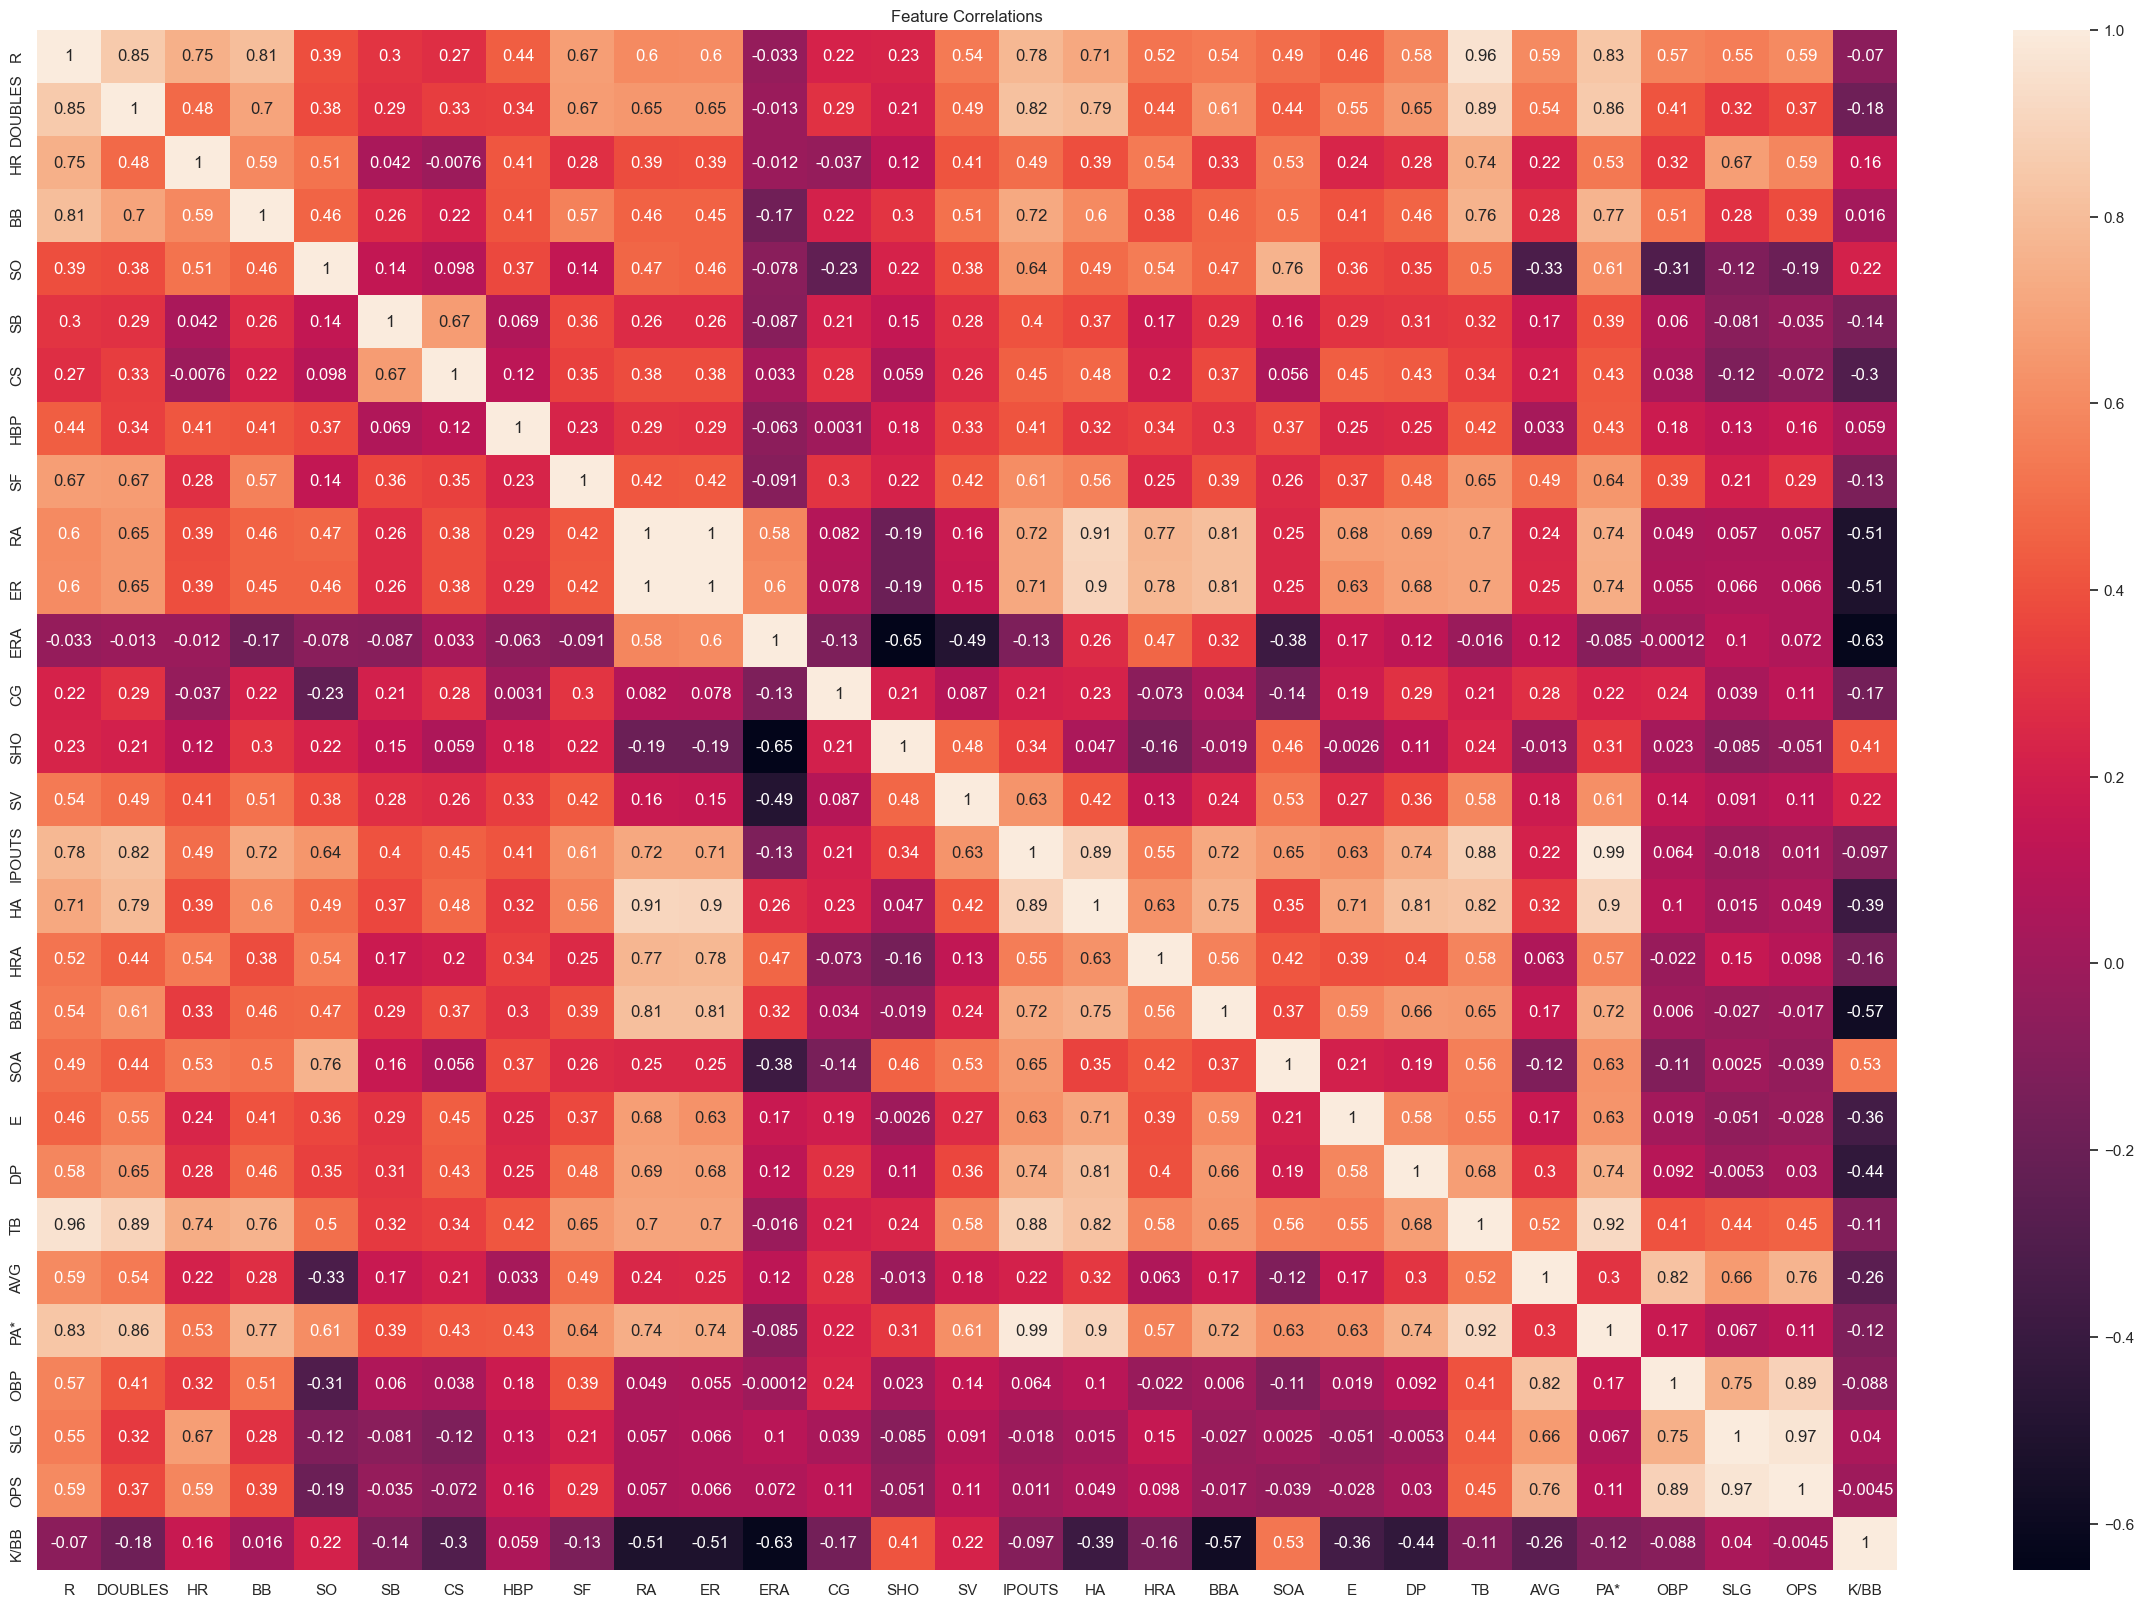

In [175]:
sns.set(rc={'figure.figsize':(30,20)}, font_scale = 1)
sns.heatmap(all_teams[num_cols].corr(method = 'pearson', numeric_only=True),annot=True).set(title = "Feature Correlations")
plt.show()

## Splitting dataset into training and testing

In [158]:
X_train, X_test, y_train, y_test = train_test_split(all_teams.drop(columns = cat_cols + ['WSWIN', 'DIVWIN', 'Playoff_Appearance']), all_teams["Playoff_Appearance"],
                                                    test_size = 0.20, random_state = 42, stratify=all_teams["Playoff_Appearance"])

X_train.head()

,R,DOUBLES,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPOUTS,HA,HRA,BBA,SOA,E,DP,TB,AVG,PA*,OBP,SLG,OPS,K/BB
590,706,261,198,478,1341,89,22,86,44,672,626,3.98,3,15,50,4251,1234,152,608,1225,84,137,2202,0.243506,5959,0.313308,0.411512,0.724819,2.014803
422,676,279,121,471,905,115,50,35,53,845,794,4.97,7,3,44,4310,1553,176,551,1035,121,138,2238,0.273733,6163,0.331008,0.399358,0.730365,1.878403
49,694,239,182,524,1326,80,34,79,32,886,818,5.09,4,5,38,4339,1578,209,590,932,141,152,2176,0.244872,6144,0.317708,0.39499,0.712698,1.579661
161,804,300,190,660,1277,106,55,47,60,715,675,4.22,5,7,45,4315,1427,141,528,1154,87,146,2378,0.260837,6165,0.343066,0.440534,0.783599,2.185606
374,672,288,216,449,1482,60,37,69,28,713,665,4.2,1,8,42,4279,1395,210,491,1357,94,129,2333,0.243204,6027,0.307118,0.425652,0.73277,2.763747


# Let's evaluate 3 types of models for classifying Playoff Appearances

## Logisitic Regressor

In [160]:
logit = LogisticRegression(max_iter=1000, penalty='elasticnet', solver = 'saga', l1_ratio=0)
logit.fit(X_train, y_train)

c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(l1_ratio=0, max_iter=1000, penalty='elasticnet',
                   solver='saga')

<Axes: title={'center': 'Logisitic Regression Feature Importances'}>

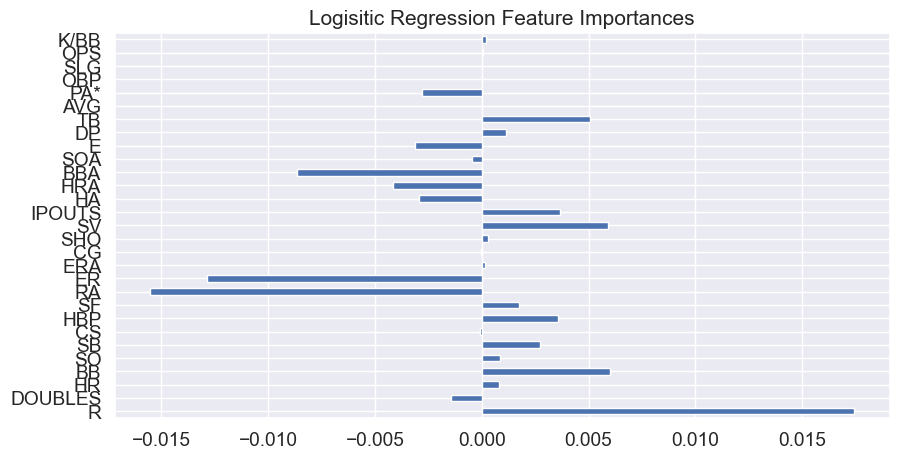

In [161]:
logit_importances = logit.coef_.tolist()[0]
logit_feature_importances = pd.Series(logit_importances, index=logit.feature_names_in_)
logit_feature_importances.plot(kind='barh', title = 'Logisitic Regression Feature Importances')

## Decision Trees (Random Forest Classifier, Gini Decision Tree)

In [162]:
forest = RandomForestClassifier(n_estimators=1000)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [163]:
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=4)
tree_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [164]:
forest_feature_importance = pd.DataFrame(index = forest.feature_names_in_, data=forest.feature_importances_, columns = ['Feature_Importance'])

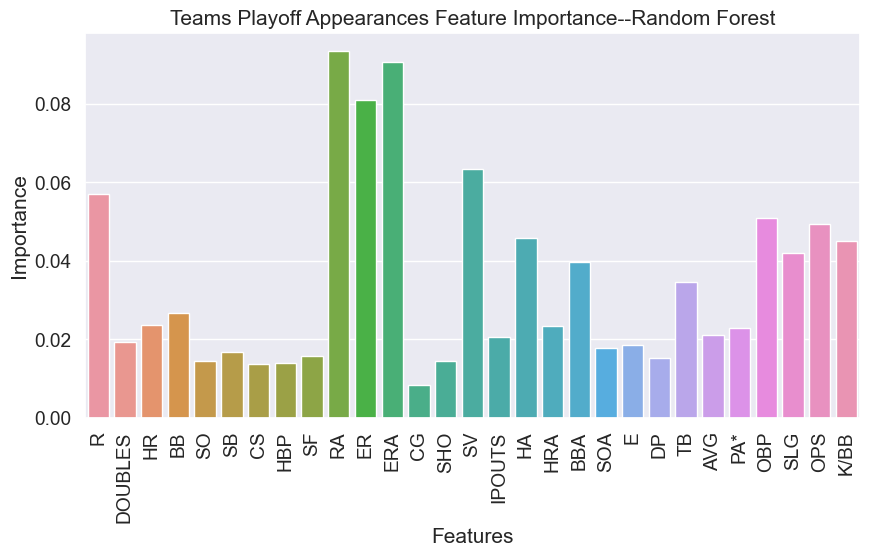

In [165]:
sns.barplot(x = forest.feature_names_in_, y = forest.feature_importances_).set(title = "Teams Playoff Appearances Feature Importance--Random Forest", xlabel='Features', ylabel='Importance')
plt.xticks(rotation=90)
plt.show()

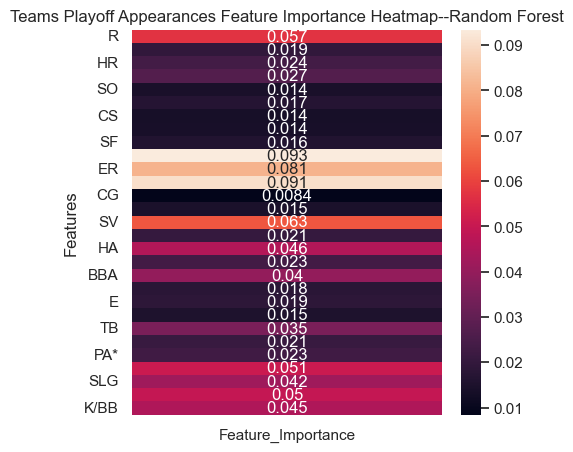

In [166]:
sns.set(rc={'figure.figsize':(5,5)}, font_scale = 1)
sns.heatmap(forest_feature_importance, annot=True).set(title = "Teams Playoff Appearances Feature Importance Heatmap--Random Forest", ylabel='Features')
plt.show()

# Evaluate Model Performance on Training Data
> Sanity check for model performance, expectations are that the model's perform very well for predictions

In [167]:
print(f"Area Under Curve Scores\nRandom Forest: {roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])}\nLogistic Regression: {round(roc_auc_score(y_train, logit.predict_proba(X_train)[:, 1]),2)}\nDecision Tree: {round(roc_auc_score(y_train, tree_gini.predict_proba(X_train)[:, 1]),2)}")

Area Under Curve Scores
Random Forest: 1.0
Logistic Regression: 0.95
Decision Tree: 0.91


In [168]:
top_features = forest_feature_importance.loc[forest_feature_importance['Feature_Importance'] > np.quantile(forest_feature_importance.values, 0.5)]

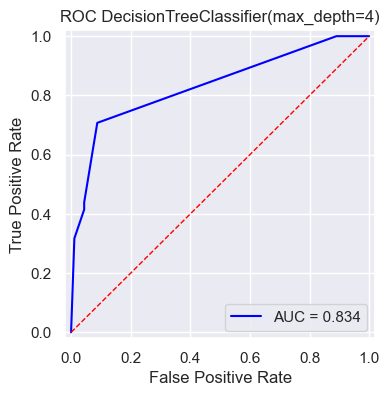

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        91
           1       0.78      0.71      0.74        41

    accuracy                           0.85       132
   macro avg       0.83      0.81      0.82       132
weighted avg       0.85      0.85      0.85       132

[[83  8]
 [12 29]]


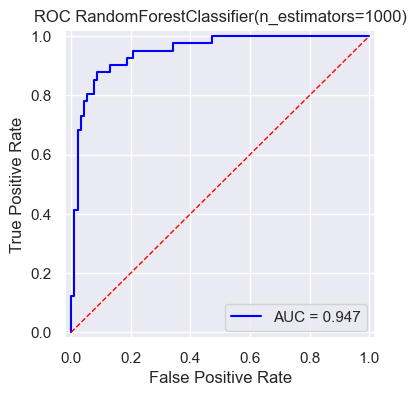

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        91
           1       0.87      0.80      0.84        41

    accuracy                           0.90       132
   macro avg       0.89      0.87      0.88       132
weighted avg       0.90      0.90      0.90       132

[[86  5]
 [ 8 33]]


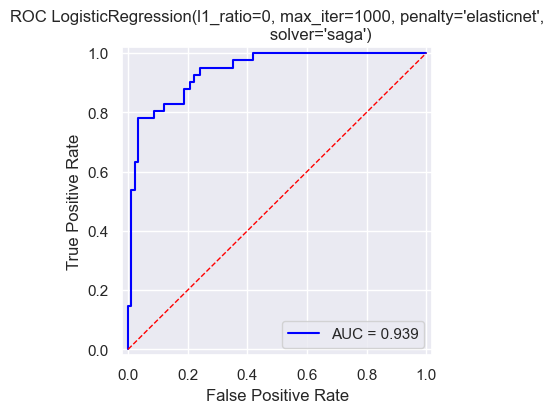

              precision    recall  f1-score   support

           0       0.91      0.95      0.92        91
           1       0.86      0.78      0.82        41

    accuracy                           0.89       132
   macro avg       0.89      0.86      0.87       132
weighted avg       0.89      0.89      0.89       132

[[86  5]
 [ 9 32]]


In [170]:
sns.set(rc={'figure.figsize':(4,4
                             )}, font_scale = 1)
# ROC curve
models_trained = [tree_gini, forest, logit]
for model in models_trained:    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=model.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:, 1])
    
    plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
    plt.title("ROC " + str(model))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.show()
    
    print(classification_report(y_true=y_test, y_pred=model.predict(X_test)))
    print(confusion_matrix(y_true=y_test, y_pred=model.predict(X_test)))

In [171]:
test_outcomes = X_test.copy()
test_outcomes['predictions_RF'] = forest.predict(X_test)
test_outcomes['predictions_DT_gini'] = tree_gini.predict(X_test)
test_outcomes['predictions_logit'] = logit.predict(X_test)
test_outcomes['actual_outcome'] = y_test
test_outcomes['TEAMID'] = all_teams['NAME']

In [172]:
test_outcomes.head()

,R,DOUBLES,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPOUTS,HA,HRA,BBA,SOA,E,DP,TB,AVG,PA*,OBP,SLG,OPS,K/BB,predictions_RF,predictions_DT_gini,predictions_logit,actual_outcome,TEAMID
493,619,241,149,466,1259,104,35,30,35,651,608,3.76,8,11,43,4370,1359,166,449,1166,72,155,2027,0.233892,6025,0.295602,0.368948,0.66455,2.596882,0,0,0,0,Seattle Mariners
258,670,320,131,478,1071,101,51,60,45,812,745,4.68,5,11,28,4294,1509,190,525,1103,108,139,2130,0.253021,5962,0.318517,0.395984,0.714502,2.100952,0,0,0,0,Montreal Expos
347,703,265,177,539,1344,57,23,44,51,635,577,3.62,4,13,41,4304,1366,145,364,1342,90,125,2185,0.251105,6062,0.321016,0.402542,0.723559,3.686813,1,1,1,0,Washington Nationals
431,587,276,126,463,1207,87,36,33,33,866,784,5.0,1,6,31,4235,1567,167,538,1026,127,120,2011,0.241924,5915,0.304142,0.373375,0.677517,1.907063,0,0,0,0,Pittsburgh Pirates
494,718,287,103,483,1097,118,39,29,61,649,593,3.68,5,14,53,4353,1361,142,489,1237,115,134,2205,0.268982,6131,0.327353,0.396725,0.724078,2.529652,1,1,0,1,San Francisco Giants


In [173]:
test_outcomes['actual_outcome'].value_counts(), test_outcomes['predictions_logit'].value_counts(), test_outcomes['predictions_DT_gini'].value_counts(), test_outcomes['predictions_RF'].value_counts()

(actual_outcome
 0    91
 1    41
 Name: count, dtype: int64,
 predictions_logit
 0    95
 1    37
 Name: count, dtype: int64,
 predictions_DT_gini
 0    95
 1    37
 Name: count, dtype: int64,
 predictions_RF
 0    94
 1    38
 Name: count, dtype: int64)

# Validation Dataset to come